In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil
from dateutil.relativedelta import relativedelta
import datetime


In [3]:
df_loan = pd.read_csv("./data-set/loan.csv")

### Phase 1 : Data Understanding

In [198]:
# List Columns 
df_loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)

*__Our Understanding of few key columns__*

<table>
<thead>
<tr>
  <th>Column Name</th>
  <th>Details</th>
</tr>
</thead>
<tbody>
<tr><td>collections_12_mths_ex_med</td><td>Number of collections in 12 months excluding medical collections. Can be ignored, mostly NA/0 values</td></tr>
<tr><td>funded_amnt</td><td>Amount that was funded by the investors. In few cases this will be lesser than the Loan Amount, the remianing amount is problably lent by LC dirctly</td></tr>
<tr><td>int_rate</td><td>Interest Rate on the loan</td></tr>
<tr><td>last_pymnt_amnt</td><td>Last total payment amount received. This will be 0 for Charged off</td></tr>
<tr><td>last_pymnt_d</td><td>Last month payment was received</td></tr>
<tr><td>loan_status</td><td>Current status of the loan</td></tr>
<tr><td>mths_since_last_major_derog</td><td>Months since most recent 90-day or worse rating</td></tr>
<tr><td>mths_since_last_record</td><td>months since the last (derogatory) public  records</td></tr>
<tr><td>open_acc</td><td>The number of open credit lines in the borrower's credit file. Ranges from 2 - 44</td></tr>
<tr><td>out_prncp_inv</td><td>Remaining outstanding principal for portion of total amount funded by investors</td></tr>
<tr><td>pub_rec</td><td>Number of derogatory public records.Another piece of data Lending Club provides is the number of public records on file. This is pulled from the credit report, so don’t confuse it with criminal public records. Credit report public records are things like bankruptcy, foreclosure, tax liens, and past-due child support.</td></tr>
<tr><td>recoveries</td><td>Recovery after defauls</td></tr>
<tr><td>revol_util</td><td>Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.</td></tr>
<tr><td>sub_grade</td><td>The majority of loans is either graded as B or C?—?together these correspond to more than 50% of the loan population.While there is a considerable amount of A graded or “prime” loans (~17%), there is a small amount of G graded, or “uncollectible” loans (~0,06%). </td></tr>
<tr><td>term</td><td>loan term.Only 2 term is available 36 months and 60 months</td></tr>
<tr><td>total_pymnt</td><td>Payments received to date for total amount funded</td></tr>
<tr><td>total_rec_int</td><td>Interest received to date</td></tr>
<tr><td>verification_status</td><td>Not verified, Verified (by LC) and Source verified are the options</td></tr>
</tbody>
</table>

In [199]:
# Dropping the columns that are not required
null_series = df_loan.isnull().sum()
df_new = pd.DataFrame(null_series)
df_new.reset_index(inplace=True)
columns=df_new[df_new[0] == 39717]
columns=np.array(columns['index'])
df_loan = df_loan.drop(columns,axis=1)

#dropping collections_12_mths_ex_med as all values are either 0 or NA
df_loan = df_loan.drop(['collections_12_mths_ex_med'],axis=1)
df_loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

In [200]:
#Printing the total number of columns in the data set after dropping the irrelevant columns
df_loan.columns.size

56

### Phase 2 : Data Cleaning & Manipulation

In [4]:
# Converting the relevant date columns to datetime objects
df_loan['earliest_cr_line'] = pd.to_datetime(df_loan['earliest_cr_line'],format='%b-%y')
df_loan['issue_d'] = pd.to_datetime(df_loan['issue_d'],format='%b-%y')
df_loan['last_credit_pull_d'] = pd.to_datetime(df_loan['last_credit_pull_d'],format='%b-%y')
df_loan['last_pymnt_d'] = pd.to_datetime(df_loan['last_pymnt_d'],format='%b-%y')
df_loan['next_pymnt_d'] = pd.to_datetime(df_loan['next_pymnt_d'],format='%b-%y')
df_loan[['earliest_cr_line','issue_d','last_credit_pull_d','last_pymnt_d','next_pymnt_d']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 5 columns):
earliest_cr_line      39717 non-null datetime64[ns]
issue_d               39717 non-null datetime64[ns]
last_credit_pull_d    39715 non-null datetime64[ns]
last_pymnt_d          39646 non-null datetime64[ns]
next_pymnt_d          1140 non-null datetime64[ns]
dtypes: datetime64[ns](5)
memory usage: 1.5 MB


In [6]:
#Printing the range of the date values after formatting
print("earliest_cr_line:  ", df_loan['earliest_cr_line'].min(), " to ", df_loan['earliest_cr_line'].max())
print("issue_d:  ", df_loan['issue_d'].min(), " to ", df_loan['issue_d'].max())
print("last_credit_pull_d:  ", df_loan['last_credit_pull_d'].min(), " to ", df_loan['last_credit_pull_d'].max())
print("last_pymnt_d:  ", df_loan['last_pymnt_d'].min(), " to ", df_loan['last_pymnt_d'].max())
print("next_pymnt_d:  ", df_loan['next_pymnt_d'].min(), " to ", df_loan['next_pymnt_d'].max())

earliest_cr_line:   1969-02-01 00:00:00  to  2068-12-01 00:00:00
issue_d:   2007-06-01 00:00:00  to  2011-12-01 00:00:00
last_credit_pull_d:   2007-05-01 00:00:00  to  2016-05-01 00:00:00
last_pymnt_d:   2008-01-01 00:00:00  to  2016-05-01 00:00:00
next_pymnt_d:   2016-06-01 00:00:00  to  2016-07-01 00:00:00


In [7]:
#earliest_cr_line column has values in the future due to ambiguity with two-digit year value in data. So date values greater 
#than 2011 need to be adjusted to previous century (1900s)
df_loan['earliest_cr_line_corrected'] = 0
df_loan.loc[df_loan['earliest_cr_line'] > '2012-01-01', 'earliest_cr_line_corrected'] = df_loan['earliest_cr_line'].dt.year-100
df_loan.loc[df_loan['earliest_cr_line'] < '2012-01-01', 'earliest_cr_line_corrected'] = df_loan['earliest_cr_line']
df_loan['earliest_cr_line_corrected'] = pd.to_datetime(df_loan['earliest_cr_line_corrected'])
df_loan['earliest_cr_line_corrected']
df_loan = df_loan.drop(['earliest_cr_line'],axis=1)
df_loan.rename(columns = {'earliest_cr_line_corrected':'earliest_cr_line'}, inplace = True)

In [8]:
#Checking the range of date values for the earliest_cr_line column
print("earliest_cr_line:  ", df_loan['earliest_cr_line'].min(), " to ", df_loan['earliest_cr_line'].max())

earliest_cr_line:   1969-02-01 00:00:00  to  2008-11-01 00:00:00


In [9]:
# Checking the data types of the relevant columns containing numeric values
df_loan[['installment',
          'dti',
          'delinq_2yrs',
          'inq_last_6mths',
          'revol_bal',
          'total_rec_prncp',
          'total_rec_late_fee',
          'funded_amnt',
          'mths_since_last_record',
          'open_acc',
          'out_prncp_inv',
          'total_pymnt',
          'last_pymnt_amnt',
          'id',
          'int_rate',
          'pub_rec',
          'revol_util',
          'total_rec_int',
          'recoveries',
          'loan_amnt',
          'funded_amnt_inv',
          'annual_inc',
          'mths_since_last_delinq',
          'total_acc',
          'out_prncp',
          'total_pymnt_inv']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 26 columns):
installment               39717 non-null float64
dti                       39717 non-null float64
delinq_2yrs               39717 non-null int64
inq_last_6mths            39717 non-null int64
revol_bal                 39717 non-null int64
total_rec_prncp           39717 non-null float64
total_rec_late_fee        39717 non-null float64
funded_amnt               39717 non-null int64
mths_since_last_record    2786 non-null float64
open_acc                  39717 non-null int64
out_prncp_inv             39717 non-null float64
total_pymnt               39717 non-null float64
last_pymnt_amnt           39717 non-null float64
id                        39717 non-null int64
int_rate                  39717 non-null object
pub_rec                   39717 non-null int64
revol_util                39667 non-null object
total_rec_int             39717 non-null float64
recoveries                

In [15]:
#Checking the data in the 2 columns with numeric data but are not recognized as numeric data types
df_loan[['int_rate','revol_util']].head()

,int_rate,revol_util
0,10.65,83.7
1,15.27,9.4
2,15.96,98.5
3,13.49,21.0
4,12.69,53.9


In [13]:
#Based on analysis in previous step, int_rate and revol_util columns are not being recognized as numeric data types as they 
#have % symbol in the data. So both these columns need to be converted to numeric types after stripping off the % symbol from
#the data

#Splitting the columns on % character
int_rate = df_loan['int_rate'].str.split('%',n=1,expand=True)
revol_util = df_loan['revol_util'].str.split('%',n=1,expand=True)

#Assigning the numeric values after stripping off the % characters to the original columns
df_loan['int_rate'] = int_rate
df_loan['revol_util'] = revol_util

#Casting the columns to float types
df_loan['int_rate'] = df_loan['int_rate'].astype(float)
df_loan['revol_util'] = df_loan['revol_util'].astype(float)

In [209]:
#Checking that the 2 columns int_rate and revol_util are now being recognized as numeric data types
df_loan[['int_rate','revol_util']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 2 columns):
int_rate      39717 non-null float64
revol_util    39667 non-null float64
dtypes: float64(2)
memory usage: 620.7 KB


__DERIVED METRICS__

In [210]:
#Adding some derived metrics for using during analysis

#Adding loan_default column: 1 for Charged Off loans and 0 for other cases
df_loan['loan_default'] = np.where(df_loan['loan_status'] == 'Charged Off',1,0)

#Creating a binned column for interest rates
int_rate_bins = [0,5,10,15,20,25]
df_loan['int_rate_bins'] = pd.cut(df_loan['int_rate'], bins=int_rate_bins)

### Phase 3 : Data Analysis

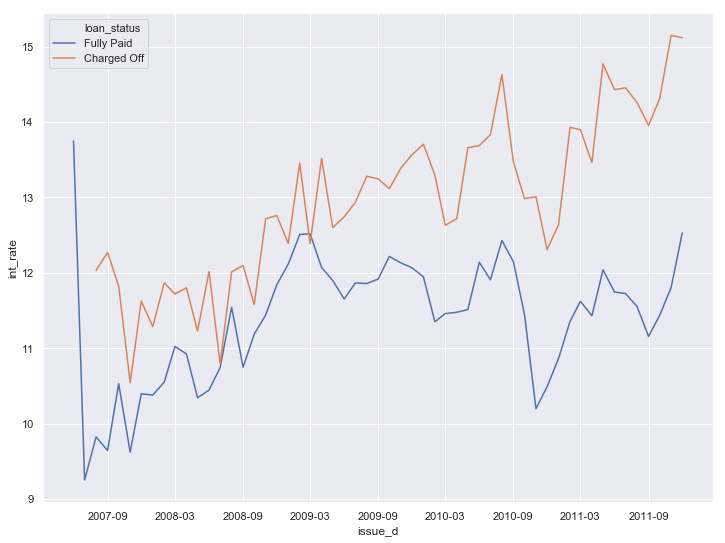

In [221]:
#Interest rate fluctuations over time
df_int_rate = df_loan[['issue_d','int_rate','loan_status']]
df_int_rate['issue_d_year'] = df_loan['issue_d'].dt.year
df_int_rate['issue_d_month'] = df_loan['issue_d'].dt.month
df_filtered = df_int_rate[df_int_rate['loan_status'] != 'Current']
sns.set(rc={'figure.figsize':(12,9)})
ax = sns.lineplot(x="issue_d", y="int_rate",ci=None,hue="loan_status",data=df_filtered)


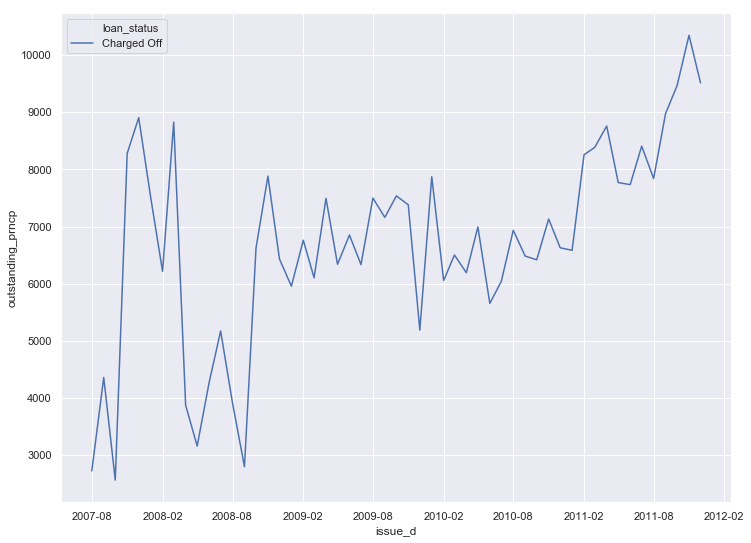

In [235]:
df1 = df_loan[['loan_status','issue_d','loan_amnt','funded_amnt','total_pymnt','out_prncp','out_prncp_inv','total_rec_prncp']]
df1['outstanding_prncp'] = df1['funded_amnt'] - df1['total_rec_prncp']

df2 = df1[df1['loan_status']=='Charged Off']

sns.set(rc={'figure.figsize':(12,9)})
ax = sns.lineplot(x="issue_d", y="outstanding_prncp",ci=None,hue="loan_status",data=df2)


In [264]:
df2 = df_loan[['loan_status','issue_d','loan_amnt','funded_amnt','total_pymnt','out_prncp','out_prncp_inv','total_rec_prncp']]
df2['outstanding_prncp'] = df2['funded_amnt'] - df2['total_rec_prncp']
df2['issue_dyymon']
df2.head()
#df3 = df2[df2['loan_status']=='Charged Off']
#df3.head()
#df3_by_yearmon = df3.groupby(['issue_dyear','issue_dmonth'],as_index=False)

In [265]:
df4 = df3_by_yearmon[['outstanding_prncp']].sum()

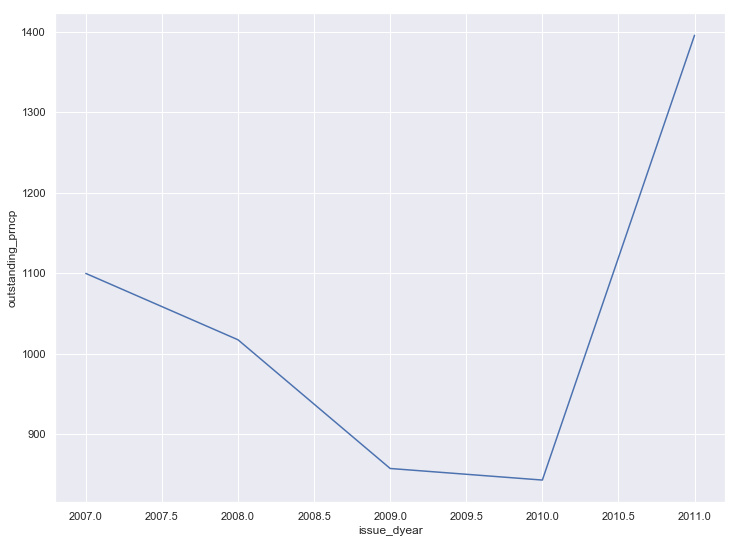

In [266]:
sns.set(rc={'figure.figsize':(12,9)})
ax = sns.lineplot(x="issue_dyear", y="outstanding_prncp",ci=None,data=df2)

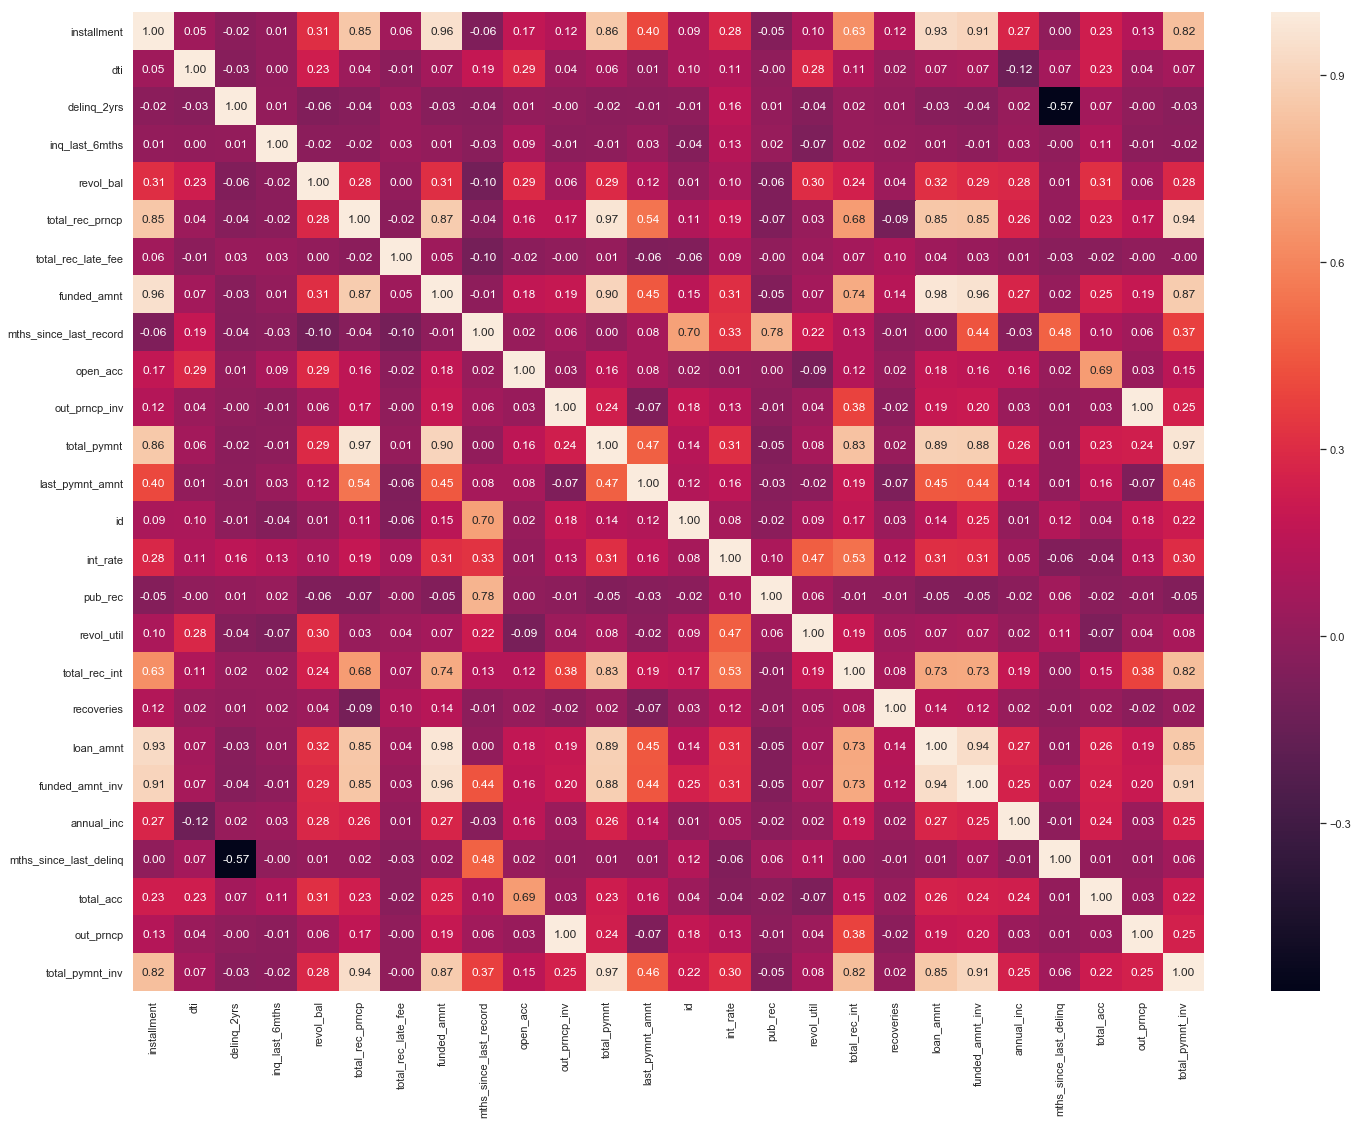

In [270]:
df_numeric = df_loan[['installment',
                      'dti',
                      'delinq_2yrs',
                      'inq_last_6mths',
                      'revol_bal',
                      'total_rec_prncp',
                      'total_rec_late_fee',
                      'funded_amnt',
                      'mths_since_last_record',
                      'open_acc',
                      'out_prncp_inv',
                      'total_pymnt',
                      'last_pymnt_amnt',
                      'id',
                      'int_rate',
                      'pub_rec',
                      'revol_util',
                      'total_rec_int',
                      'recoveries',
                      'loan_amnt',
                      'funded_amnt_inv',
                      'annual_inc',
                      'mths_since_last_delinq',
                      'total_acc',
                      'out_prncp',
                      'total_pymnt_inv']]
sns.set(rc={'figure.figsize':(24,18)})
sns.heatmap(df_numeric.corr(), annot=True, fmt=".2f")
plt.show()

#Highly co-related pairs of columns
# installment - funded_amnt
# installment - loan_amnt
# installment - funded_amnt_inv
# total_rec_prncp - total_pymnt
# total_rec_prcp - total_pymnt_inv
# funded_amnt - total_pymnt
# funded_amnt - loan_amnt
# funded_amnt - funded_amnt_inv
# out_prncp - out_prncp_inv
# total_pymnt - total_pymnt_inv
# loan_amnt - funded_amnt_inv
# funded_amnt_inv - total_pymnnt_inv

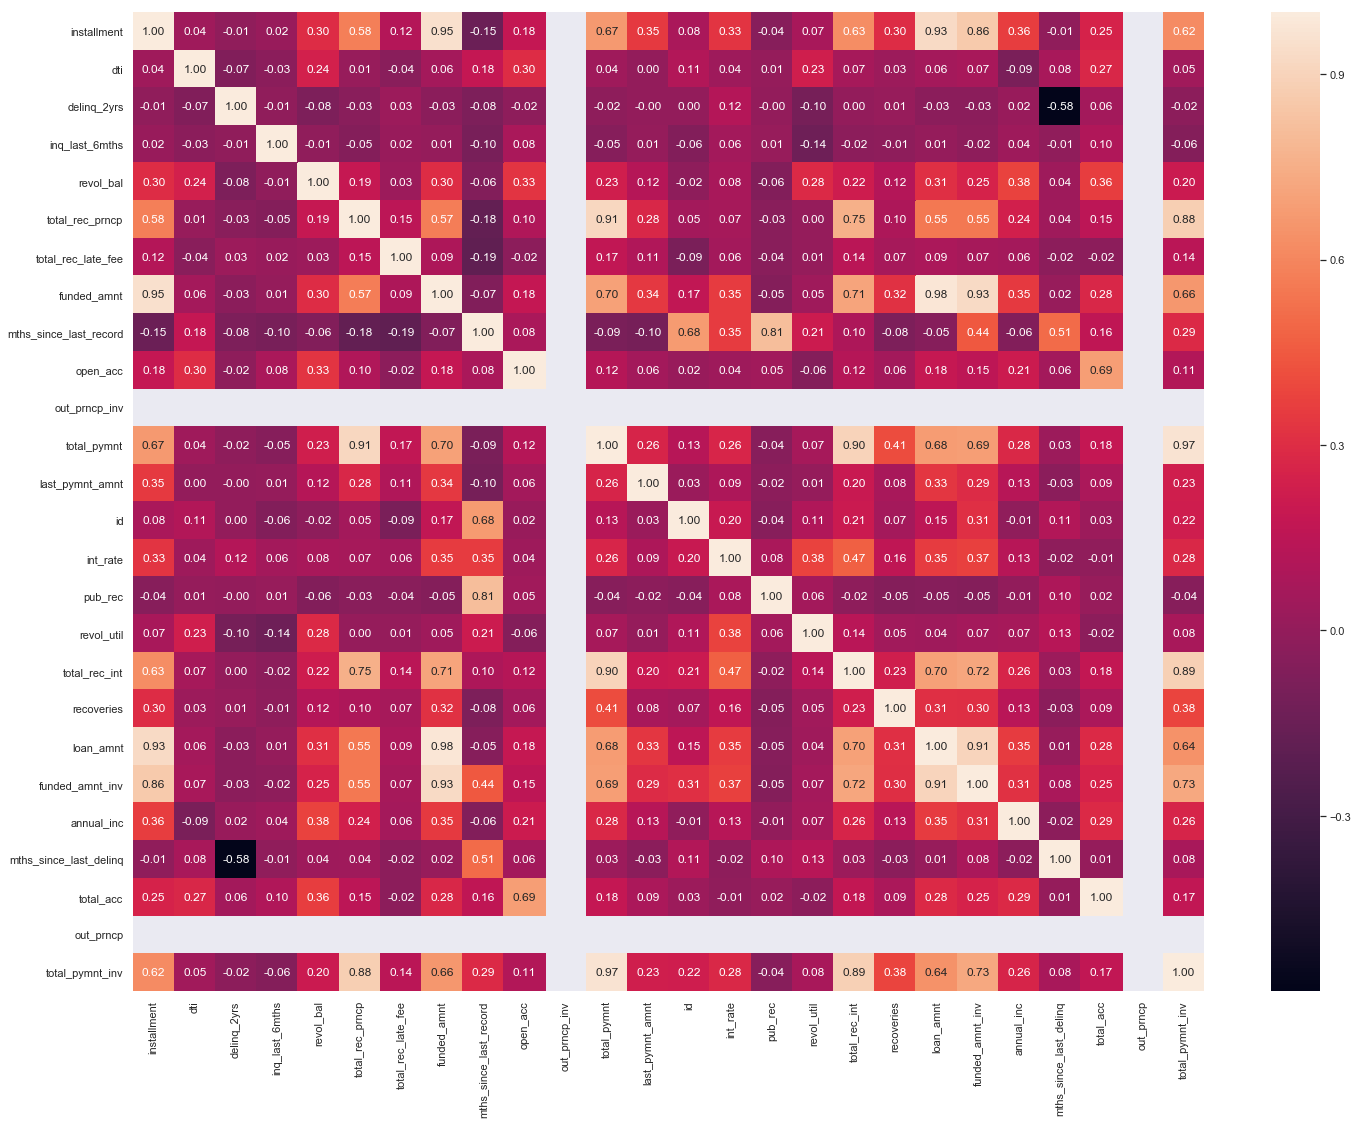

In [271]:
df_numeric1 = df_loan[['installment',
                      'dti',
                      'delinq_2yrs',
                      'inq_last_6mths',
                      'revol_bal',
                      'total_rec_prncp',
                      'total_rec_late_fee',
                      'funded_amnt',
                      'mths_since_last_record',
                      'open_acc',
                      'out_prncp_inv',
                      'total_pymnt',
                      'last_pymnt_amnt',
                      'id',
                      'int_rate',
                      'pub_rec',
                      'revol_util',
                      'total_rec_int',
                      'recoveries',
                      'loan_amnt',
                      'funded_amnt_inv',
                      'annual_inc',
                      'mths_since_last_delinq',
                      'total_acc',
                      'out_prncp',
                      'total_pymnt_inv',
                      'loan_status']]
sns.set(rc={'figure.figsize':(24,18)})
df_numeric_ch_off = df_numeric1[df_numeric1['loan_status']=='Charged Off']
sns.heatmap(df_numeric_ch_off.corr(), annot=True, fmt=".2f")
plt.show()

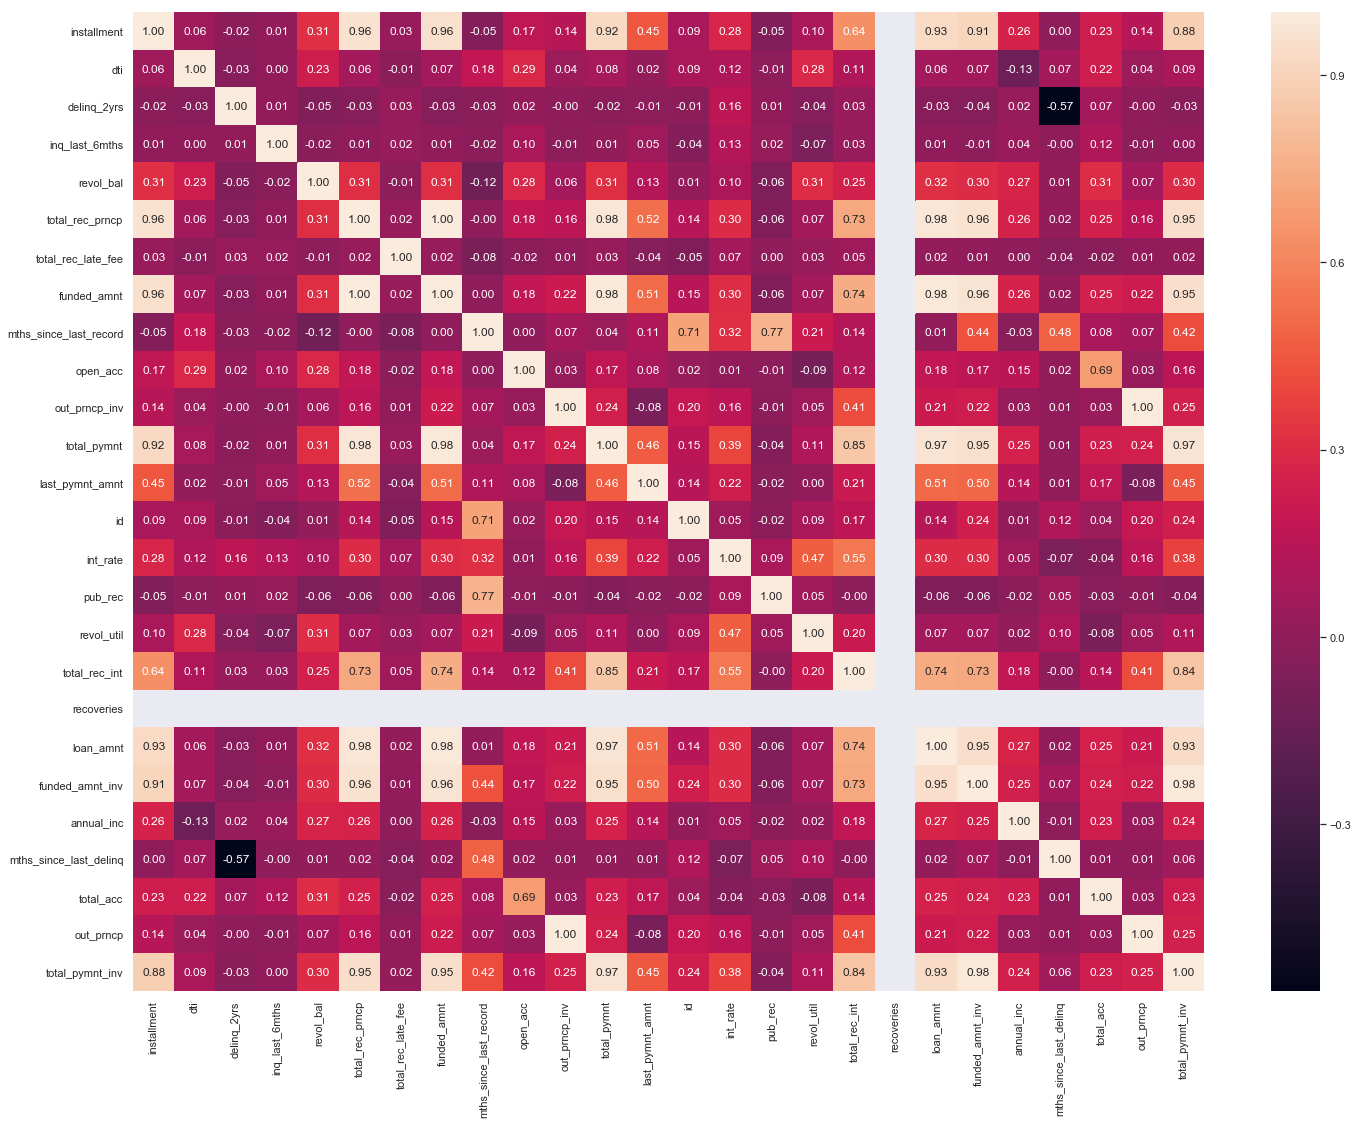

In [17]:
df_numeric2 = df_loan[['installment',
                      'dti',
                      'delinq_2yrs',
                      'inq_last_6mths',
                      'revol_bal',
                      'total_rec_prncp',
                      'total_rec_late_fee',
                      'funded_amnt',
                      'mths_since_last_record',
                      'open_acc',
                      'out_prncp_inv',
                      'total_pymnt',
                      'last_pymnt_amnt',
                      'id',
                      'int_rate',
                      'pub_rec',
                      'revol_util',
                      'total_rec_int',
                      'recoveries',
                      'loan_amnt',
                      'funded_amnt_inv',
                      'annual_inc',
                      'mths_since_last_delinq',
                      'total_acc',
                      'out_prncp',
                      'total_pymnt_inv',
                      'loan_status']]
sns.set(rc={'figure.figsize':(24,18)})
df_numeric_nch_off = df_numeric2[df_numeric2['loan_status'] !='Charged Off']
sns.heatmap(df_numeric_nch_off.corr(), annot=True, fmt=".2f")
plt.show()